음성분석

In [1]:
!pip install praat-parselmouth
# 필요한 라이브러리 설치
!pip install pydub
!apt-get install ffmpeg  # Colab에서 FFmpeg 설치


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 64.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [8]:
from pydub import AudioSegment

# M4A 파일을 WAV로 변환
audio = AudioSegment.from_file("real_test.m4a", format="m4a")
audio.export("real_test.wav", format="wav")
audio2 = AudioSegment.from_file("seoul_test4.mp3",format = "mp3")
audio2.export("seoul_test4.wav",format="wav")

<_io.BufferedRandom name='seoul_test4.wav'>

In [4]:
!pip install noisereduce

real_test_only.wav 파일이 생성되었습니다.


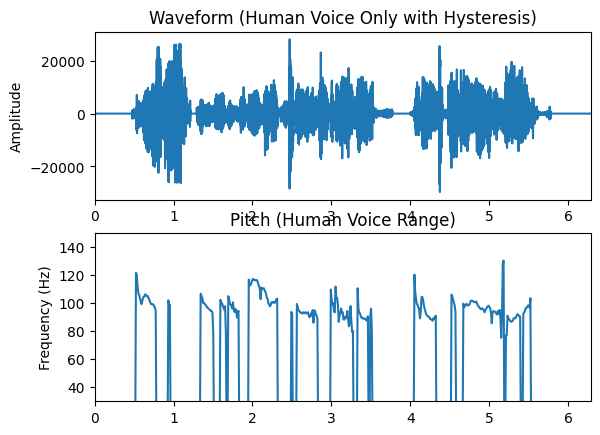

In [27]:
#인간의 음역대만 따온 버전. 인간의 음역대가 끝나고 여유 시간을 둬서 완성도 있게 필터함.
import parselmouth
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

# 1. WAV 파일 로드
file_path = "real_test.wav"

# WAV 파일 읽기 (샘플링 레이트와 데이터 반환)
sampling_rate, data = wav.read(file_path)

# 스테레오일 경우 단일 채널로 변환
if len(data.shape) > 1:
    data = data.mean(axis=1).astype(np.int16)

# 2. parselmouth로 음성 분석
snd = parselmouth.Sound(data, sampling_rate)

# 피치 분석 (사람의 음역대)
pitch = snd.to_pitch()
human_voice_range = (30, 255)  # 사람 목소리 범위

# 피치 값과 해당 시간 단계 가져오기
pitch_values = pitch.selected_array["frequency"]
time_steps = pitch.xs()

# 3. 끊김 방지용 히스테리시스 필터 적용
filtered_data = np.zeros_like(data, dtype=np.float32)  # 원본과 동일한 크기의 배열 생성
prev_in_range = False  # 이전 샘플이 인간 음역대에 있었는지 추적

# 히스테리시스: 피치가 범위를 벗어났더라도 일정 구간을 유지 (50ms)
extend_ms = 50  # 유지할 길이 (밀리초)
silence_after_ms = 200  # 말이 끝난 후 유지할 여유 시간 (밀리초)
extend_samples = int(sampling_rate * extend_ms / 1000)  # 샘플 수로 변환
silence_samples = int(sampling_rate * silence_after_ms / 1000)  # 여유 시간 샘플 수

for i, t in enumerate(time_steps):
    index = int(t * sampling_rate)  # 시간 단계를 샘플 인덱스로 변환

    # 현재 피치가 인간 음역대에 해당하는지 확인
    in_range = human_voice_range[0] <= pitch_values[i] <= human_voice_range[1]

    if in_range or prev_in_range:
        # 앞뒤로 extend_ms만큼 구간을 유지
        start = max(0, index - extend_samples)
        end = min(len(data), index + extend_samples + silence_samples)
        filtered_data[start:end] = data[start:end]

    # 현재 상태를 다음 반복에 전달
    prev_in_range = in_range

# 4. 결과를 WAV 파일로 저장
output_file = "real_test_only.wav"
wav.write(output_file, sampling_rate, filtered_data.astype(np.int16))

print(f"{output_file} 파일이 생성되었습니다.")

# 5. 파형 및 피치 그래프 그리기
plt.figure()

# 파형 그리기
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(filtered_data)) / sampling_rate, filtered_data)
plt.xlim([0, len(filtered_data) / sampling_rate])
plt.ylabel("Amplitude")
plt.title("Waveform (Human Voice Only with Hysteresis)")

# 피치 그리기 (인간 음역대만 표시)
plt.subplot(2, 1, 2)
plt.plot(time_steps, pitch_values, "-", markersize=5, label="Pitch")
plt.xlim([0, len(data) / sampling_rate])
plt.ylim(30, 150)  # 피치 범위 설정
plt.ylabel("Frequency (Hz)")
plt.title("Pitch (Human Voice Range)")
plt.show()


tts 파일 분석

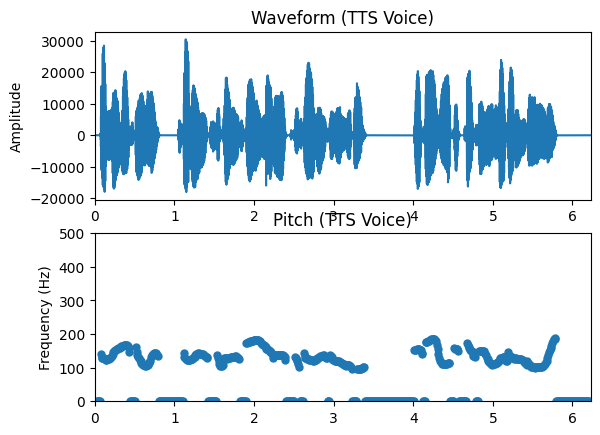

In [17]:
import parselmouth
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

# 1. WAV 파일 로드
file_path = "seoul_test4.wav"  # TTS 음성 파일 경로로 변경

# wav 파일 읽기 (샘플링 레이트와 데이터 반환)
sampling_rate, data = wav.read(file_path)

# 스테레오일 경우 단일 채널로 변환
if len(data.shape) > 1:
    data = data.mean(axis=1).astype(np.int16)

# 2. parselmouth로 음성 분석
snd = parselmouth.Sound(data, sampling_rate)

# 피치 분석
pitch = snd.to_pitch()

# 피치 값과 해당 시간 단계 가져오기
pitch_values_tts = pitch.selected_array["frequency"]
time_steps_tts = pitch.xs()



# 4. 파형 및 피치 그래프 그리기
plt.figure()

# 파형 그리기
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.xlim([0, len(data) / sampling_rate])
plt.ylabel("Amplitude")
plt.title("Waveform (TTS Voice)")

# 피치 그리기
plt.subplot(2, 1, 2)
plt.plot(time_steps_tts, pitch_values_tts, "o", markersize=5, label="Pitch")
plt.xlim([0, len(data) / sampling_rate])
plt.ylim(0, 500)  # 피치 범위 설정
plt.ylabel("Frequency (Hz)")
plt.title("Pitch (TTS Voice)")
plt.show()


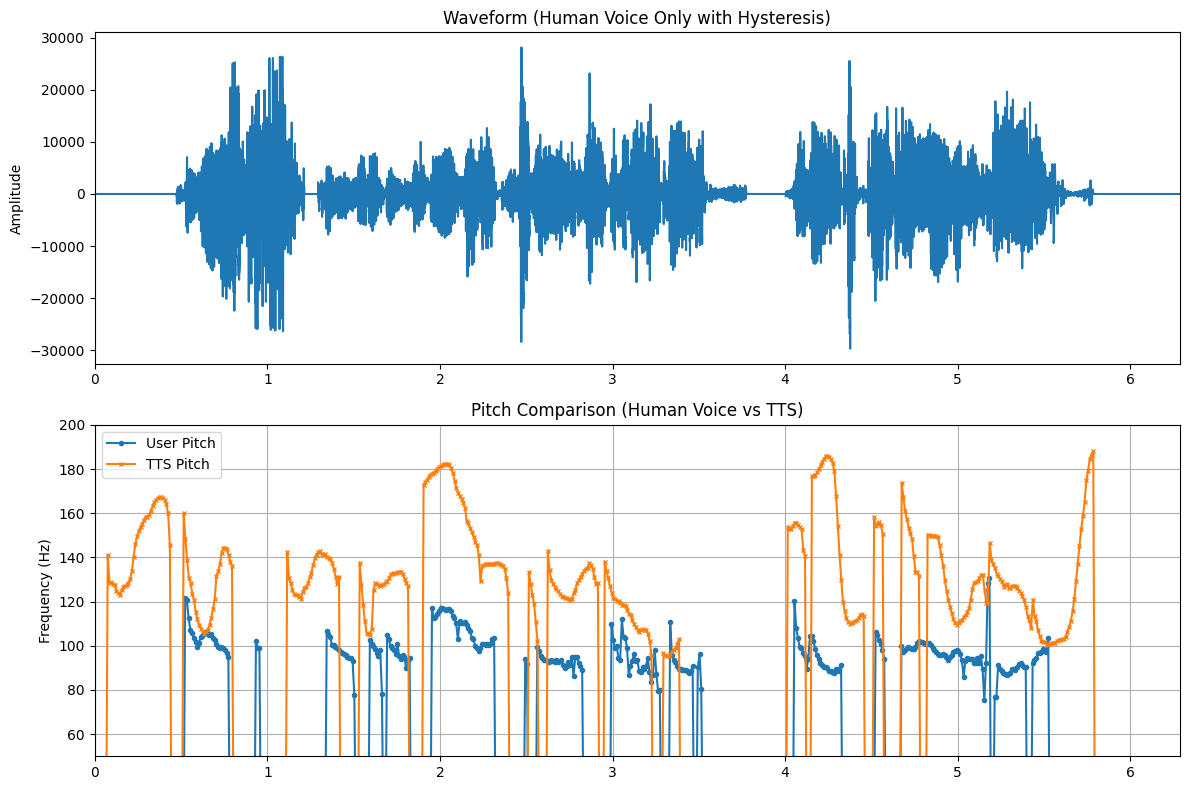

In [31]:
# 파형 그리기
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(filtered_data)) / sampling_rate, filtered_data)
plt.xlim([0, len(filtered_data) / sampling_rate])
plt.ylabel("Amplitude")
plt.title("Waveform (Human Voice Only with Hysteresis)")

# 피치 그리기 (인간 음역대만 표시)
plt.subplot(2, 1, 2)
plt.plot(time_steps, pitch_values, label="User Pitch", marker='o', markersize=3)
plt.plot(time_steps_tts, pitch_values_tts, label="TTS Pitch", marker='x', markersize=3)
plt.xlim([0, len(filtered_data) / sampling_rate])
plt.ylim(50, 200)  # 피치 범위 설정
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Comparison (Human Voice vs TTS)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

타임스탬프

In [6]:
!pip install git+https://github.com/openai/whisper.git
!pip install torch  # 필요한 경우 PyTorch도 설치

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-wyj7ul85
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-wyj7ul85
  Resolved https://github.com/openai/whisper.git to commit 5979f03701209bb035a0a466f14131aeb1116cbb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.2 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803560 sha256=67eb7cf2f7bac72484c56e76b659ecb699020af6768cf981f49c9bbf07b119e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-x8pvxqcy/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper


타임스탬프를 구하는 함수

In [44]:
import whisper

def extract_word_timestamps(audio_file_path):
    # Whisper 모델 로드
    model = whisper.load_model("base")
    result = model.transcribe(audio_file_path, word_timestamps=True)

    word_intervals = []

    # 단어별 시작 및 끝 시간 추출
    for segment in result["segments"]:
        if "words" in segment:
            for word in segment["words"]:
                if 'word' in word and 'start' in word and 'end' in word:
                    word_intervals.append({
                        'word': word['word'],
                        'start': word['start'],
                        'end': word['end']
                    })

    return word_intervals

사용자 타임스탬프

In [45]:


# 예제 사용
audio_file_path = 'real_test_only.wav'  # 적절한 경로로 변경
word_intervals = extract_word_timestamps(audio_file_path)

# 출력 확인
for word_data in word_intervals:
    print(f"단어: {word_data['word']}, 시작: {word_data['start']:.2f}s, 끝: {word_data['end']:.2f}s")


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/usr/local/li

단어:  안녕하세요., 시작: 0.00s, 끝: 0.84s
단어:  저는, 시작: 1.28s, 끝: 1.44s
단어:  지금, 시작: 1.44s, 끝: 1.72s
단어:  서울, 시작: 1.72s, 끝: 2.02s
단어:  마를, 시작: 2.02s, 끝: 2.30s
단어:  구산, 시작: 2.30s, 끝: 2.60s
단어:  중입니다., 시작: 2.60s, 끝: 3.32s
단어:  이거, 시작: 3.82s, 끝: 4.20s
단어:  어디까지, 시작: 4.20s, 끝: 4.62s
단어:  올라가는, 시작: 4.62s, 끝: 5.08s
단어:  거예요., 시작: 5.08s, 끝: 5.36s


tts 타임스탬프

In [46]:


# 예제 사용
audio_file_path = 'tts_test_analyzed.wav'  # 적절한 경로로 변경
tts_word_intervals = extract_word_timestamps(audio_file_path)

# 출력 확인
for word_data in tts_word_intervals:
    print(f"단어: {word_data['word']}, 시작: {word_data['start']:.2f}s, 끝: {word_data['end']:.2f}s")


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/usr/local/li

단어:  안녕하세요., 시작: 0.00s, 끝: 0.52s
단어:  저는, 시작: 1.04s, 끝: 1.26s
단어:  지금, 시작: 1.26s, 끝: 1.68s
단어:  서울, 시작: 1.68s, 끝: 2.02s
단어:  말을, 시작: 2.02s, 끝: 2.28s
단어:  구사하는, 시작: 2.28s, 끝: 2.84s
단어:  중입니다., 시작: 2.84s, 끝: 3.30s
단어:  이거, 시작: 4.00s, 끝: 4.22s
단어:  어디까지, 시작: 4.22s, 끝: 4.84s
단어:  올라가는, 시작: 4.84s, 끝: 5.32s
단어:  거예요?, 시작: 5.32s, 끝: 5.62s


음성 비교

피치 차이로 구하는 방법

In [40]:
# 피치 차이 임계값 설정
threshold = 50

# 결과 저장
results = []

# 사용자 단어와 TTS 단어의 피치 차이 계산
for i in range(min(len(word_intervals), len(tts_word_intervals))):  # 단어 개수의 최소값으로 루프
    user_word = word_intervals[i]  # 사용자의 단어
    tts_word = tts_word_intervals[i]  # TTS 단어

    # 사용자 피치 샘플링 추출
    user_pitch_samples = pitch_values[(time_steps >= user_word['start']) & (time_steps <= user_word['end'])]

    if len(user_pitch_samples) > 0:
        user_pitch_diff = np.max(user_pitch_samples) - np.min(user_pitch_samples)

        # TTS 피치 샘플링 추출
        tts_pitch_samples = pitch_values_tts[(time_steps_tts >= tts_word['start']) & (time_steps_tts <= tts_word['end'])]

        if len(tts_pitch_samples) > 0:
            tts_pitch_diff = np.max(tts_pitch_samples) - np.min(tts_pitch_samples)

            # 피치 차이가 임계값 초과하는 경우 결과 저장
            if abs(user_pitch_diff - tts_pitch_diff) > threshold:
                results.append({
                    'user_word': user_word['word'],
                    'tts_word': tts_word['word'],
                    'user_diff': user_pitch_diff,
                    'tts_diff': tts_pitch_diff
                })

# 결과 출력
for result in results:
    print(f"사용자 단어: {result['user_word']}, TTS 단어: {result['tts_word']}, "
          f"사용자 피치 차이: {result['user_diff']}, TTS 피치 차이: {result['tts_diff']}")


사용자 단어:  안녕하세요., TTS 단어:  안녕하세요., 사용자 피치 차이: 0.0, TTS 피치 차이: 167.22702535645908
사용자 단어:  저는, TTS 단어:  저는, 사용자 피치 차이: 0.0, TTS 피치 차이: 142.33799201276508
사용자 단어:  서울, TTS 단어:  서울, 사용자 피치 차이: 117.27997824844142, TTS 피치 차이: 181.82876142515684
사용자 단어:  이거, TTS 단어:  이거, 사용자 피치 차이: 120.42802749415492, TTS 피치 차이: 183.2371759228284
사용자 단어:  어디까지, TTS 단어:  어디까지, 사용자 피치 차이: 106.18228865138491, TTS 피치 차이: 185.98454458315925
사용자 단어:  올라가는, TTS 단어:  올라가는, 사용자 피치 차이: 130.4913016352311, TTS 피치 차이: 40.54666355150948
사용자 단어:  거예요?, TTS 단어:  거예요?, 사용자 피치 차이: 103.69021695816939, TTS 피치 차이: 26.633436752267713


기울기 평균으로 구하는 방법

In [47]:
import numpy as np
import numpy.polynomial.polynomial as Polynomial

# Gradient 계산 함수
def calculate_pitch_gradients(pitch_values, time_steps):
    gradients = []

    # 다항식 보간을 위한 함수
    def polynomial_interpolation(time, pitch):
        coeffs = Polynomial.polyfit(time, pitch, deg=3)  # 3차 다항식으로 보간
        return Polynomial.polyval(time, coeffs)

    # 피치 기울기 계산
    for i in range(1, len(pitch_values)):
        if pitch_values[i] > 0 and pitch_values[i-1] > 0:  # 피치가 0보다 큰 경우에만 계산
            gradient = (pitch_values[i] - pitch_values[i-1]) / (time_steps[i] - time_steps[i-1])
            gradients.append(gradient)

    return gradients

# 세그먼트 기울기 비교 함수
def compare_segments(user_segments, tts_segments, user_pitch_values, user_time_steps, tts_pitch_values, tts_time_steps):
    highest_segment = None
    lowest_segment = None
    highest_difference = -float('inf')  # Initialize to negative infinity for maximum comparison
    lowest_difference = float('inf')    # Initialize to positive infinity for minimum comparison

    for user_segment, tts_segment in zip(user_segments, tts_segments):
        # 해당 세그먼트의 피치 값 및 타임스탬프 추출
        user_indices = [i for i, t in enumerate(user_time_steps) if user_segment['start'] <= t <= user_segment['end']]
        tts_indices = [i for i, t in enumerate(tts_time_steps) if tts_segment['start'] <= t <= tts_segment['end']]

        # 다항식 보간을 통해 피치 기울기 계산
        if user_indices and tts_indices:
            user_segment_pitch = user_pitch_values[user_indices[0]:user_indices[-1] + 1]
            user_segment_time = user_time_steps[user_indices[0]:user_indices[-1] + 1]
            tts_segment_pitch = tts_pitch_values[tts_indices[0]:tts_indices[-1] + 1]
            tts_segment_time = tts_time_steps[tts_indices[0]:tts_indices[-1] + 1]

            user_gradients = calculate_pitch_gradients(user_segment_pitch, user_segment_time)
            tts_gradients = calculate_pitch_gradients(tts_segment_pitch, tts_segment_time)

            # 기울기 차이 계산
            if user_gradients and tts_gradients:
                avg_user_gradient = np.mean(user_gradients)
                avg_tts_gradient = np.mean(tts_gradients)
                difference = avg_user_gradient - avg_tts_gradient

                # 가장 높은 기울기 차이를 기록 (양의 방향)
                if difference > highest_difference:
                    highest_difference = difference
                    highest_segment = (user_segment, tts_segment, avg_user_gradient, avg_tts_gradient)

                # 가장 낮은 기울기 차이를 기록 (음의 방향)
                if difference < lowest_difference:
                    lowest_difference = difference
                    lowest_segment = (user_segment, tts_segment, avg_user_gradient, avg_tts_gradient)

    return highest_segment, lowest_segment

# 사용자와 TTS의 타임스탬프에서 세그먼트 가져오기
user_segments = extract_word_timestamps('real_test_only.wav')  # 사용자 음성 세그먼트
tts_segments = extract_word_timestamps('tts_test_analyzed.wav')  # TTS 음성 세그먼트

# 세그먼트 비교
highest_segment, lowest_segment = compare_segments(
    user_segments, tts_segments, pitch_values, time_steps, pitch_values_tts, time_steps_tts
)

# 결과 출력
if highest_segment:
    user_segment_high, tts_segment_high, avg_user_gradient_high, avg_tts_gradient_high = highest_segment
    print(f"음성이 TTS 대비 가장 높은 기울기를 가진 세그먼트:")
    print(f"사용자 세그먼트: {user_segment_high}, TTS 세그먼트: {tts_segment_high}")
    print(f"사용자 평균 기울기: {avg_user_gradient_high:.4f}, TTS 평균 기울기: {avg_tts_gradient_high:.4f}")
    print("음성이 TTS 대비 높아요.")

if lowest_segment:
    user_segment_low, tts_segment_low, avg_user_gradient_low, avg_tts_gradient_low = lowest_segment
    print(f"음성이 TTS 대비 가장 낮은 기울기를 가진 세그먼트:")
    print(f"사용자 세그먼트: {user_segment_low}, TTS 세그먼트: {tts_segment_low}")
    print(f"사용자 평균 기울기: {avg_user_gradient_low:.4f}, TTS 평균 기울기: {avg_tts_gradient_low:.4f}")
    print("음성이 TTS 대비 낮아요.")
else:
    print("세그먼트 비교에서 차이를 찾을 수 없습니다.")


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/usr/local/li

음성이 TTS 대비 가장 높은 기울기를 가진 세그먼트:
사용자 세그먼트: {'word': ' 거예요.', 'start': 5.08, 'end': 5.36}, TTS 세그먼트: {'word': ' 거예요?', 'start': 5.32, 'end': 5.62}
사용자 평균 기울기: 214.2774, TTS 평균 기울기: -81.9911
음성이 TTS 대비 높아요.
음성이 TTS 대비 가장 낮은 기울기를 가진 세그먼트:
사용자 세그먼트: {'word': ' 지금', 'start': 1.44, 'end': 1.72}, TTS 세그먼트: {'word': ' 지금', 'start': 1.26, 'end': 1.68}
사용자 평균 기울기: -318.3429, TTS 평균 기울기: -52.3113
음성이 TTS 대비 낮아요.
